In [1]:
from typing import Optional

from xchangelib import xchange_client
import asyncio

log = []

class MyXchangeClient(xchange_client.XChangeClient):
    '''A shell client with the methods that can be implemented to interact with the xchange.'''

    def __init__(self, host: str, username: str, password: str):
        super().__init__(host, username, password)

    async def bot_handle_cancel_response(self, order_id: str, success: bool, error: Optional[str]) -> None:
        order = self.open_orders[order_id]
        print(f"{'Market' if order[2] else 'Limit'} Order ID {order_id} cancelled, {order[1]} unfilled")

    async def bot_handle_order_fill(self, order_id: str, qty: int, price: int):
        print("order fill", self.positions)

    async def bot_handle_order_rejected(self, order_id: str, reason: str) -> None:
        print("order rejected because of ", reason)


    async def bot_handle_trade_msg(self, symbol: str, price: int, qty: int):
        # print("something was traded")
        pass

    async def bot_handle_book_update(self, symbol: str) -> None:
        # print("book update")
        pass

    async def bot_handle_swap_response(self, swap: str, qty: int, success: bool):
        # print("Swap response")
        pass


    async def trade(self):
        """This is a task that is started right before the bot connects and runs in the background."""
        await asyncio.sleep(5)
        print("attempting to trade")
        await self.place_order("BRV",3, xchange_client.Side.SELL, 7)

        # Cancelling an order
        order_to_cancel = await self.place_order("BRV",3, xchange_client.Side.BUY, 5)
        await asyncio.sleep(5)
        await self.cancel_order(order_to_cancel)

        # Placing Swap requests
        await self.place_swap_order('toJAK', 1)
        await asyncio.sleep(5)
        await self.place_swap_order('fromSCP', 1)
        await asyncio.sleep(5)

        # Placing an order that gets rejected for exceeding qty limits
        await self.place_order("BRV",1000, xchange_client.Side.SELL, 7)
        await asyncio.sleep(5)

        # Placing a market order
        market_order_id = await self.place_order("BRV",10, xchange_client.Side.SELL)
        print("Market Order ID:", market_order_id)
        await asyncio.sleep(5)

        # Viewing Positions
        print("My positions:", self.positions)

    async def view_books(self):
        """Prints the books every 1 seconds."""
        while True:
            await asyncio.sleep(1)
            log.append(self.order_books)
            for security, book in self.order_books.items():
                sorted_bids = sorted((k,v) for k,v in book.bids.items() if v != 0)
                sorted_asks = sorted((k,v) for k,v in book.asks.items() if v != 0)
                print(f"Bids for {security}:\n{sorted_bids}")
                print(f"Asks for {security}:\n{sorted_asks}")

    async def start(self):
        """
        Creates tasks that can be run in the background. Then connects to the exchange
        and listens for messages.
        """
        # asyncio.create_task(self.trade())
        asyncio.create_task(self.view_books())
        await self.connect()


async def main():
    SERVER = 'staging.uchicagotradingcompetition.com:3333' # run on sandbox
    my_client = MyXchangeClient(SERVER, "princeton","nidoqueen-chansey-9131")
    await my_client.start()
    return
    

In [2]:
loop = asyncio.get_event_loop()
result = loop.run_until_complete(main())

RuntimeError: This event loop is already running

In [4]:
import pickle
with open('log.pickle', 'rb') as file:
    log = pickle.load(file)

In [21]:
log

[{'JMS': OrderBook(bids={}, asks={}),
  'JAK': OrderBook(bids={9619: 0, 9617: 0, 9618: 0, 9615: 0, 9614: 0, 9616: 0, 9643: 0, 9642: 0, 9641: 0, 9640: 0, 9639: 0, 9638: 0, 9686: 0, 9685: 0, 9684: 0, 9683: 0, 9682: 0, 9681: 0, 9718: 0, 9717: 0, 9716: 0, 9715: 0, 9714: 0, 9713: 0, 9790: 0, 9789: 0, 9788: 0, 9787: 0, 9786: 0, 9785: 0, 9838: 0, 9837: 0, 9836: 0, 9835: 0, 9834: 0, 9833: 0, 9881: 0, 9880: 0, 9879: 0, 9878: 0, 9877: 0, 9876: 0, 9951: 0, 9950: 0, 9949: 0, 9948: 0, 9947: 0, 9946: 0, 9972: 0, 9971: 0, 9970: 0, 9969: 0, 9968: 0, 9967: 0, 9921: 30, 9920: 40, 9919: 50, 9918: 60, 9917: 70, 9916: 80}, asks={9649: 0, 9650: 0, 9651: 0, 9652: 0, 9653: 0, 9654: 0, 9692: 0, 9693: 0, 9694: 0, 9695: 0, 9696: 0, 9697: 0, 9724: 0, 9725: 0, 9726: 0, 9727: 0, 9728: 0, 9729: 0, 9796: 0, 9797: 0, 9798: 0, 9799: 0, 9800: 0, 9801: 0, 9844: 0, 9845: 0, 9846: 0, 9847: 0, 9848: 0, 9849: 0, 9887: 0, 9888: 0, 9889: 0, 9890: 0, 9891: 0, 9892: 0, 9957: 0, 9958: 0, 9959: 0, 9960: 0, 9961: 0, 9962: 0, 9978: 

## Case 1

Way to keep track of the order book, our open orders
1. Analyse the statistics? Mean reverting, trend following, this feeds into the fair value. 

Way to compute the fair value based on the order book
1. Straightforward: average of best bid, best ask 
2. 2nd level: more bid vol than ask, likely to go up, vice versa
3. ML techniques (order book at t) -> (order book at t+1)

Trading strategy (Jerry, Menon)
1. Penny bid $1 above the best bid, $1 below the best ask (or even $2) 
2. Different levels of penny bidding (1,2,3,4)
3. To compensate for informed trading, use fade 
4. Parameters: fair value, edge, fade, size and slack

In [8]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("Case1_Historical.csv")
df  

,Unnamed: 0,EPT,DLO,MKU,IGM,BRV
0,0,3882,4744,4189,6808,4592
1,0,4958,5282,5408,5570,5612
2,0,4298,4778,4802,5300,5221
3,0,5056,5097,5216,5112,5264
4,0,4928,5157,5441,5690,5642
...,...,...,...,...,...,...
247,0,4878,5566,6090,6173,6626
248,0,3956,4720,4454,6186,4938
249,0,4706,4854,5030,4676,5270
250,0,5218,5191,5254,5269,5194


<Axes: >

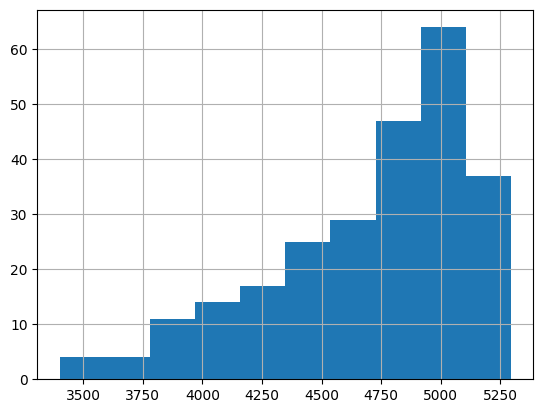

In [11]:
df['EPT'].hist()

<Axes: >

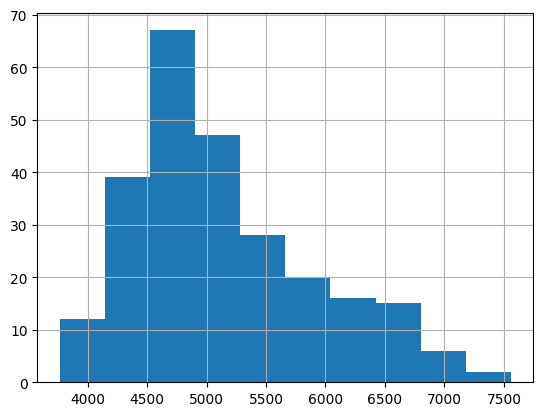

In [15]:
df['BRV'].hist()

In [19]:

# Assuming 'data' is your histogram data
data = np.log(df['BRV'])

# List of distributions to try
distributions = [stats.norm, stats.expon, stats.lognorm]

# Fit each distribution and store the sum of squared errors
sse = {}
for dist in distributions:
    params = dist.fit(data)
    sse[dist.name] = np.sum((data - dist(*params).rvs(len(data)))**2)

# Find the distribution with the lowest sum of squared errors
best_fit = min(sse, key=sse.get)

print(f"The best fitting distribution is {best_fit}")

The best fitting distribution is norm


<Axes: >

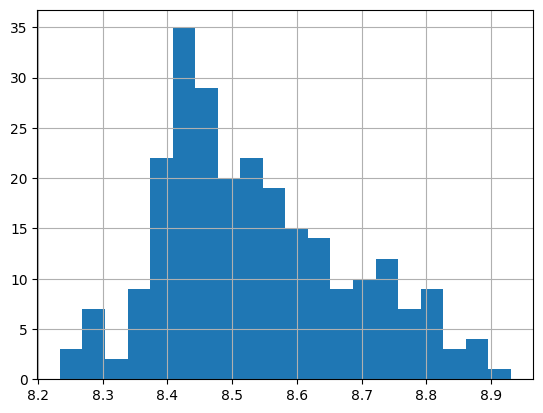

In [29]:
x = np.log(df['BRV'])
x.hist(bins = 20)

Prices follow a log normal distribution.

In [31]:
from typing import Optional

from xchangelib import xchange_client
import asyncio

xchange_client.SYMBOLS

['JMS', 'JAK', 'EPT', 'DLO', 'MKU', 'IGM', 'BRV', 'SCP']